# Machine Learning with Two Hearts
### Cassandra Overney and Khang Vu

This notebook contains our work for a DrivenData competition, [Machine Learning with a Heart](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/109/), which strives to use data science to detect heart disease, the number one cause of death worldwide. The task is to predict the presence or absence of heart disease given various data about a patient, such as resting blood pressure, maximum heart rate, EKG readings, sex, and age.

## Overview of Data

The data comes from the Statlog Heart dataset, which is part of the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/statlog+(heart)). The terms of use are [here](http://archive.ics.uci.edu/ml/citation_policy.html). The UCI Machine Learning Repository contains a collection of datasets that are used by the machine learning community to analyze machine learning algorithms. The datasets in this repository are open to the public. According to the citation policy, we need to include a citation when publishing material based on their data (reference resources section).

We hope to use the heart data to attempt various machine learning algorithms to see which ones have the highest accuracy, precision, sensitivity, and specificity. We  first [downloaded](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/data/) the data. There are four data files:
- Training Values: contains data for 13 features and is used to train the models with patients making up the rows and features making up the columns.
- Training Labels: contains the output (0 for no heart disease and 1 for heart disease) for the patients in Training Values.    
- Test Values: same structure as Training Values but with different patients. This data is used to make predictions after training the model.
- Submission Format: same structure as Training Labels but without the `heart_disease_present` data. We will need to fill up that column to be scored. 

The 13 features include:
- `slope_of_peak_exercise_st_segment` (type: `int`): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- `thal` (type: `categorical`): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- `resting_blood_pressure` (type: `int`): resting blood pressure
- `chest_pain_type` (type: `int`): chest pain type (4 values)
- `num_major_vessels` (type: `int`): number of major vessels (0-3) colored by flourosopy
- `fasting_blood_sugar_gt_120_mg_per_dl` (type: `binary`): fasting blood sugar > 120 mg/dl
- `resting_ekg_results` (type: `int`): resting electrocardiographic results (values 0,1,2)
- `serum_cholesterol_mg_per_dl` (type: `int`): serum cholestoral in mg/dl
- `oldpeak_eq_st_depression` (type: `float`): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- `sex` (type: `binary`): 0: female, 1: male
- `age` (type: `int`): age in years
- `max_heart_rate_achieved` (type: `int`): maximum heart rate achieved (beats per minute)
- `exercise_induced_angina` (type: `binary`): exercise-induced chest pain (0: False, 1: True)

## Data Cleaning
Before running any analysis, we need to read in the data and replace the values of `thal` with numerical values.

In [1]:
import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
import statsmodels.formula.api as smf
from itertools import permutations

In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_labels = pd.read_csv('data/train_labels.csv')
train = pd.merge(train_values, train_labels, on="patient_id")

Set index to `patient_id`

In [3]:
train = train.set_index('patient_id')
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Replace `thal` values with numbers. 
- `normal`: 0
- `fixed_defect`: 1
- `reversible_defect`: 2

In [4]:
train['thal'] = train['thal'].replace('normal', 0)
train['thal'] = train['thal'].replace('fixed_defect', 1)
train['thal'] = train['thal'].replace('reversible_defect', 2)
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,0,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,0,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,0,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,2,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,2,178,1,0,0,2,270,4.2,1,59,145,0,0


## Exploratory Data Analysis

Todo: write intro

### Response Variable
Plot the distribution of `heart_disease_present`

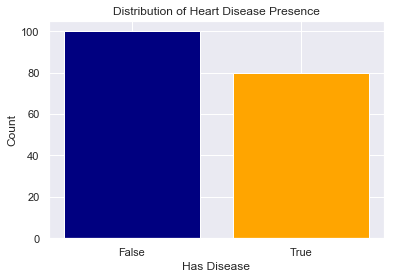

In [5]:
data = train['heart_disease_present'].value_counts().values
title='Distribution of Heart Disease Presence'
bars = ('False', 'True')
y_pos = np.arange(len(bars))
plt.bar(y_pos, data, color=['navy', 'orange'])
plt.xticks(y_pos, bars)
plt.title(title)
plt.xlabel('Has Disease')
plt.ylabel('Count')
plt.show()

The data is pretty well-balanced, so we don't need to take any steps to equalize the classes when we train our models.

### Histograms

Plot the categorical variables with histograms. We also include quantitative variables with less than 4 unique values.  

In [6]:
histo_vars = ['thal', 'exercise_induced_angina', 'chest_pain_type', 'num_major_vessels', 'slope_of_peak_exercise_st_segment', 'sex', 'resting_ekg_results', 'fasting_blood_sugar_gt_120_mg_per_dl']
bar_names = {}
bar_names['thal'] = ['', 'normal', 'fixed_defect', 'reversible_defect', '']
bar_names['fasting_blood_sugar_gt_120_mg_per_dl'] = ['', 'False', 'True', '']
bar_names['sex'] = ['', 'Female', 'Male', '']
bar_names['exercise_induced_angina'] = ['', 'False', 'True', '']

In [7]:
def plot_histogram(x_axes, ax, df, var, title=''):
    # Be sure to only pick integer tick locations.
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    data = df[var]
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    bins = np.arange(left_of_first_bin, right_of_last_bin + d, d)
    ax.hist(data, bins)
    ax.set(xlabel=var, ylabel='Count')
    try:
        x_axes[var] = ax.get_xticks()
        ax.set_xticklabels(bar_names[var])
    except:
        x_axes[var] = ax.get_xticks()
    if title:
        ax.set(title=title)
    ax.xaxis.labelpad = 10
    return x_axes

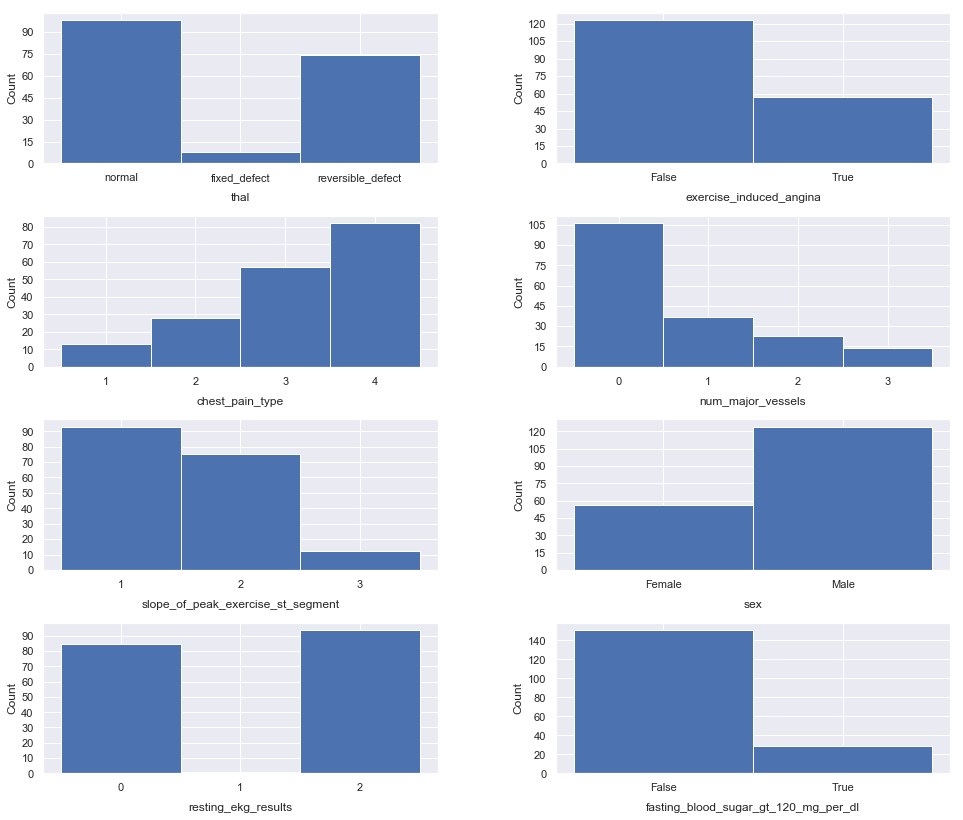

In [8]:
fig, axarr = plt.subplots(4, 2, figsize=(14,12))
x_axes = {}
counter = 0
for i in range(4):
    for j in range(2):
        x_axes = plot_histogram(x_axes=x_axes, ax=axarr[i, j], df=train, var=histo_vars[counter])
        counter += 1
plt.subplots_adjust(bottom=0, left=0, wspace=0.3, hspace=0.35)

### PMFs and CDFs

Plot the distributions of the quantitative variables with PMFs and CDFs.

In [9]:
pmf_vars = ['oldpeak_eq_st_depression', 'max_heart_rate_achieved', 'age', 'serum_cholesterol_mg_per_dl', 'resting_blood_pressure']

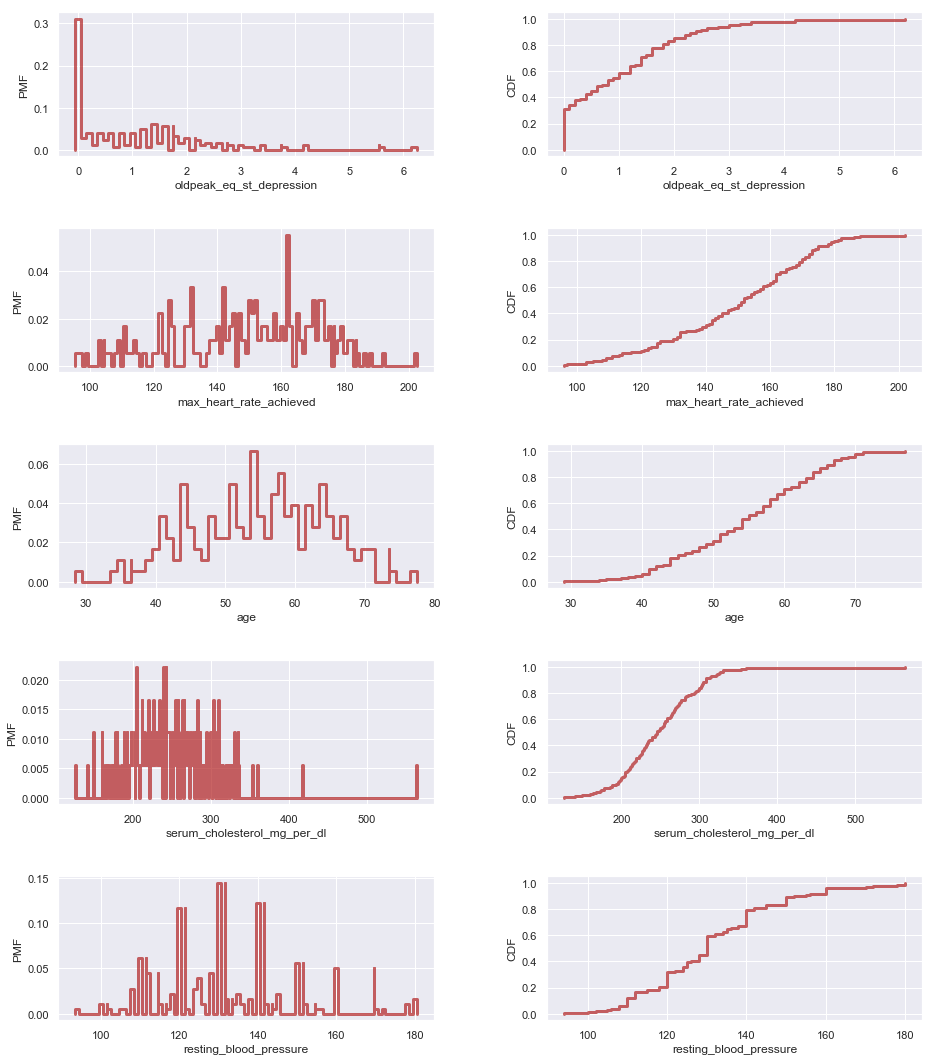

<Figure size 576x432 with 0 Axes>

In [10]:
thinkplot.Figure(figsize=(12, 14))

thinkplot.PrePlot(num=1, rows=5, cols=2)

for i in range(1, 11):
    thinkplot.SubPlot(i, label=str(i))
    counter = int((i-1)/2)
    var = pmf_vars[counter]
    
    if (i-1)%2 == 0:
        pmf = thinkstats2.Pmf(train[var])
        thinkplot.Pmf(pmf, color='firebrick')
        thinkplot.Config(xlabel=var, ylabel='PMF')
    else: 
        # Plot CDF
        cdf = thinkstats2.Cdf(train[var])
        thinkplot.Cdf(cdf, color='firebrick')
        thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.5)
thinkplot.Show()

### Histograms with Heart Disease Groups

We plot histogram distributions for presence of heart disease groups.

In [11]:
heart_disease = train[train['heart_disease_present']==1]
no_heart_disease = train[train['heart_disease_present']==0]

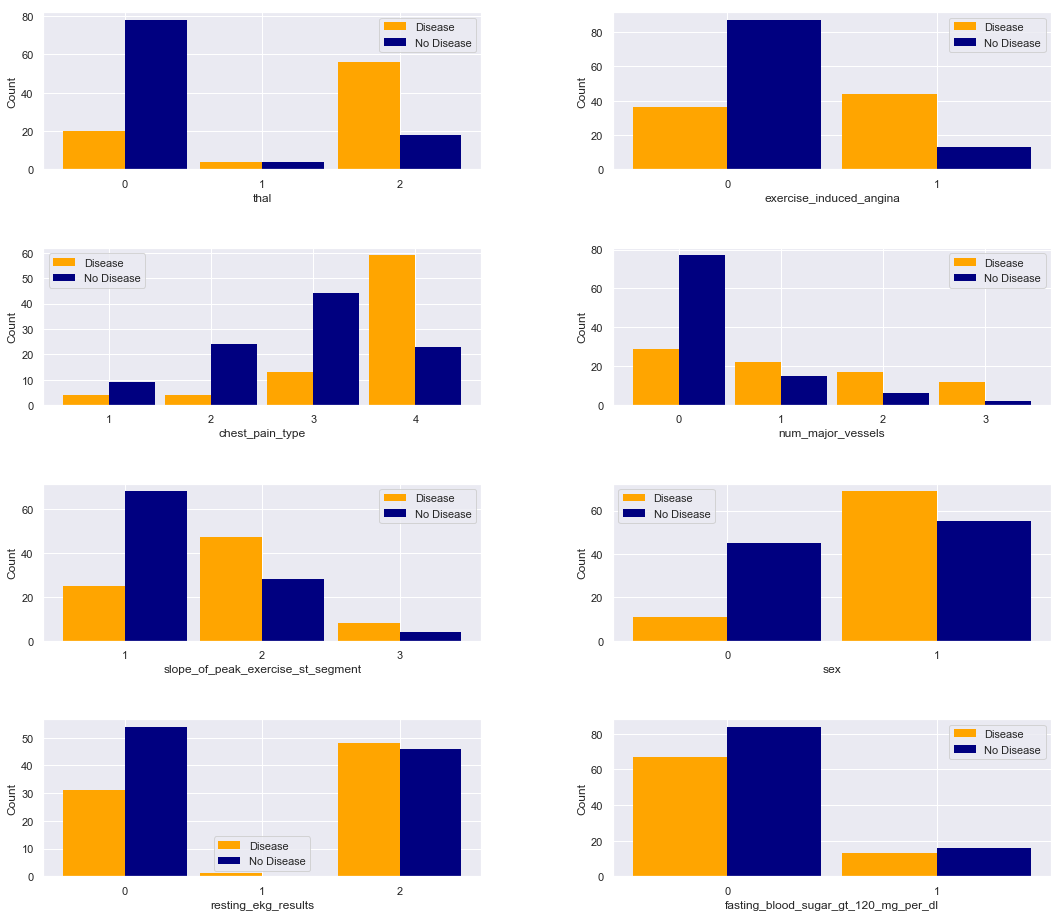

<Figure size 576x432 with 0 Axes>

In [12]:
thinkplot.Figure(figsize=(14, 12))

thinkplot.PrePlot(num=2, rows=4, cols=2)

width = 0.45

for i in range(1, 9):
    thinkplot.SubPlot(i, label=str(i))
    counter = i-1
    var = histo_vars[counter]
    heart_disease_hist = thinkstats2.Hist(heart_disease[var], label='Disease')
    no_heart_disease_hist = thinkstats2.Hist(no_heart_disease[var], label='No Disease')
    thinkplot.Hist(heart_disease_hist, align='right', width=width, color='orange', alpha=1)
    thinkplot.Hist(no_heart_disease_hist, align='left', width=width, color='navy', alpha=1)
    x_ticks = x_axes[var][1:-1]
    thinkplot.Config(xlabel=var, ylabel='Count', xticks=x_ticks)
    
thinkplot.tight_layout(bottom=0, left=0, wspace=0.3, hspace=0.5)
thinkplot.Show()

### PMFs and CDFs with Heart Disease Groups

We plot PMF and CDF distributions for presence of heart disease groups.

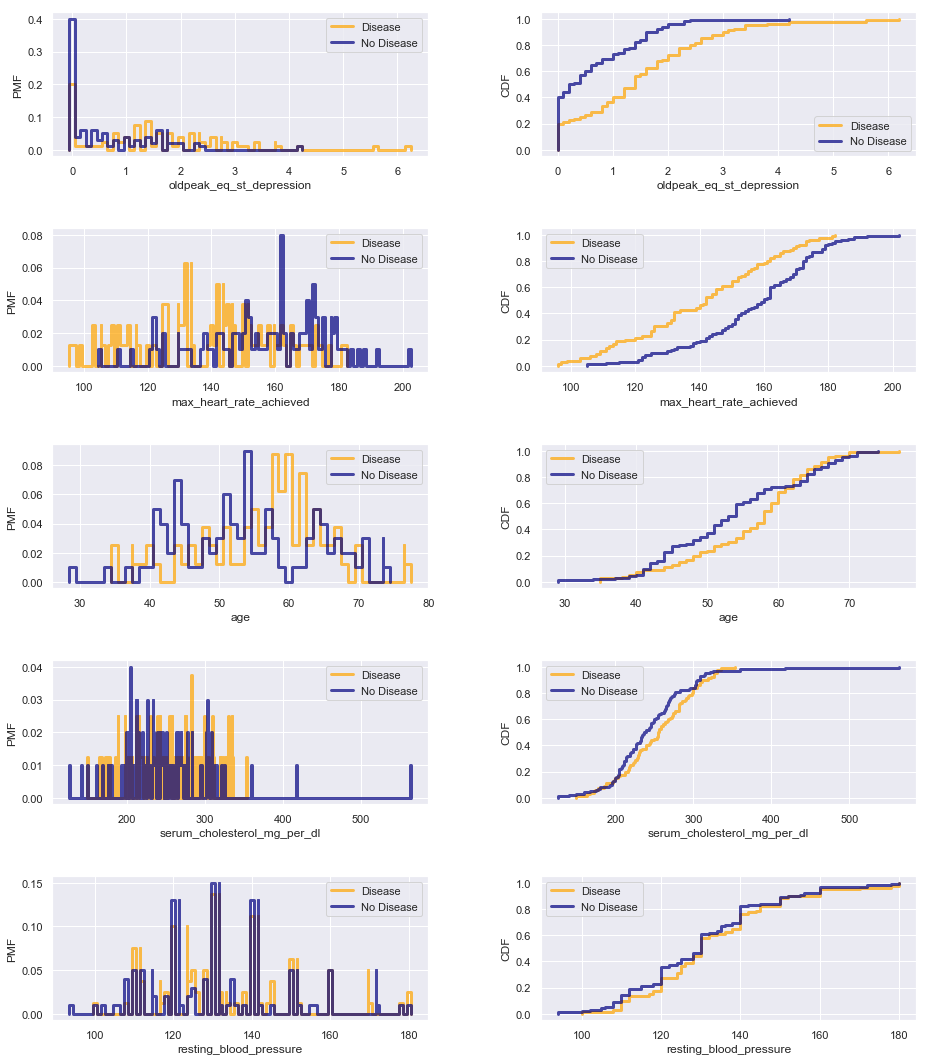

<Figure size 576x432 with 0 Axes>

In [13]:
thinkplot.Figure(figsize=(12, 14))

thinkplot.PrePlot(num=2, rows=5, cols=2)

for i in range(1, 11):
    thinkplot.SubPlot(i, label=str(i))
    counter = int((i-1)/2)
    var = pmf_vars[counter]
    
    if (i-1)%2 == 0:
        pmf_disease = thinkstats2.Pmf(heart_disease[var], label='Disease')
        pmf_no_disease = thinkstats2.Pmf(no_heart_disease[var], label='No Disease')
        thinkplot.Pmf(pmf_disease, color='orange')
        thinkplot.Pmf(pmf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='PMF')
    else: 
        # Plot CDF
        cdf_disease = thinkstats2.Cdf(heart_disease[var], label='Disease')
        cdf_no_disease = thinkstats2.Cdf(no_heart_disease[var], label='No Disease')
        thinkplot.Cdf(cdf_disease, color='orange')
        thinkplot.Cdf(cdf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.5)
thinkplot.Show()

### Scatter Plots
We plot relationships between quantitative variables with presence of heart disease groups. After making scatter plots of all permutations of `pmf_vars`, we select the following scatter plots to highlight.

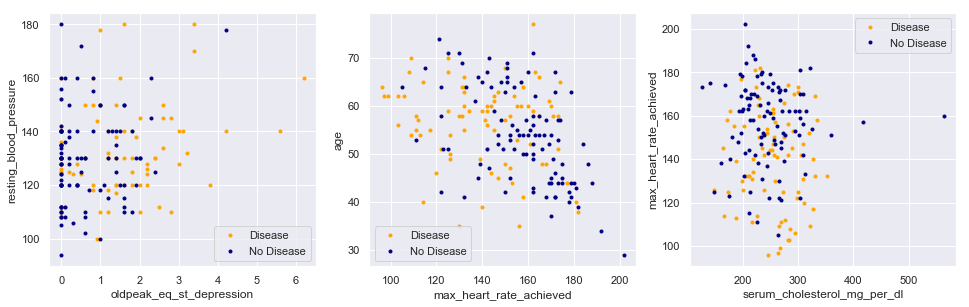

In [14]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
y_vars = ['resting_blood_pressure', 'age', 'max_heart_rate_achieved']
x_vars = ['oldpeak_eq_st_depression', 'max_heart_rate_achieved', 'serum_cholesterol_mg_per_dl']

for index, x_var in enumerate(x_vars):
    ax = axarr[index]
    y_var = y_vars[index]
    x_disease, y_disease = heart_disease[x_var], heart_disease[y_var]
    ax.plot(x_disease, y_disease, '.', alpha=1, label='Disease', color='orange')
    x_no_disease, y_no_disease = no_heart_disease[x_var], no_heart_disease[y_var]
    ax.plot(x_no_disease, y_no_disease, '.', alpha=1, label='No Disease', color='navy')
    ax.legend()
    ax.set(xlabel=x_var, ylabel=y_var)

plt.subplots_adjust(bottom=0, left=0, wspace=0.2)

Deal with zero inflation by creating binary variable `have_oldpeak`. We also set the 0 `oldpeak_eq_st_depression` values to `np.nan`.

In [24]:
have_oldpeak = train[train['oldpeak_eq_st_depression'] > 0]
no_oldpeak = train[train['oldpeak_eq_st_depression'] == 0]

have_oldpeak['have_oldpeak'] = 1
no_oldpeak['have_oldpeak'] = 0

no_oldpeak['oldpeak_eq_st_depression'] = np.nan

frames = [have_oldpeak, no_oldpeak]
train_new = pd.concat(frames)

heart = train_new.pop('heart_disease_present')
train_new['heart_disease_present'] = heart

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

Plot `have_oldpeak`

In [25]:
heart_disease = train_new[train_new['heart_disease_present']==1]
no_heart_disease = train_new[train_new['heart_disease_present']==0]

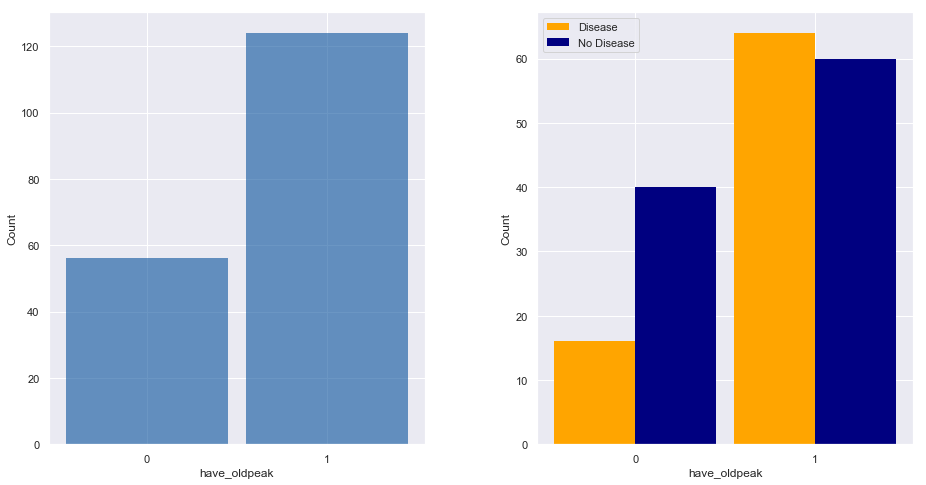

<Figure size 576x432 with 0 Axes>

In [26]:
thinkplot.Figure(figsize=(6, 8))

thinkplot.PrePlot(num=2, rows=1, cols=2)

width = 0.45

var = 'have_oldpeak'

for i in range(1, 3):
    thinkplot.SubPlot(i, label=str(i))
    if i == 1:
        hist = thinkstats2.Hist(train_new[var])
        thinkplot.Hist(hist)
        thinkplot.Config(xlabel=var, ylabel='Count', xticks=[0, 1])
    else:
        heart_disease_hist = thinkstats2.Hist(heart_disease[var], label='Disease')
        no_heart_disease_hist = thinkstats2.Hist(no_heart_disease[var], label='No Disease')
        thinkplot.Hist(heart_disease_hist, align='right', width=width, color='orange', alpha=1)
        thinkplot.Hist(no_heart_disease_hist, align='left', width=width, color='navy', alpha=1)
        thinkplot.Config(xlabel=var, ylabel='Count', xticks=[0, 1])
    
thinkplot.tight_layout(bottom=0, left=0, wspace=0.3)
thinkplot.Show()

Plot `oldpeak_eq_st_depression`

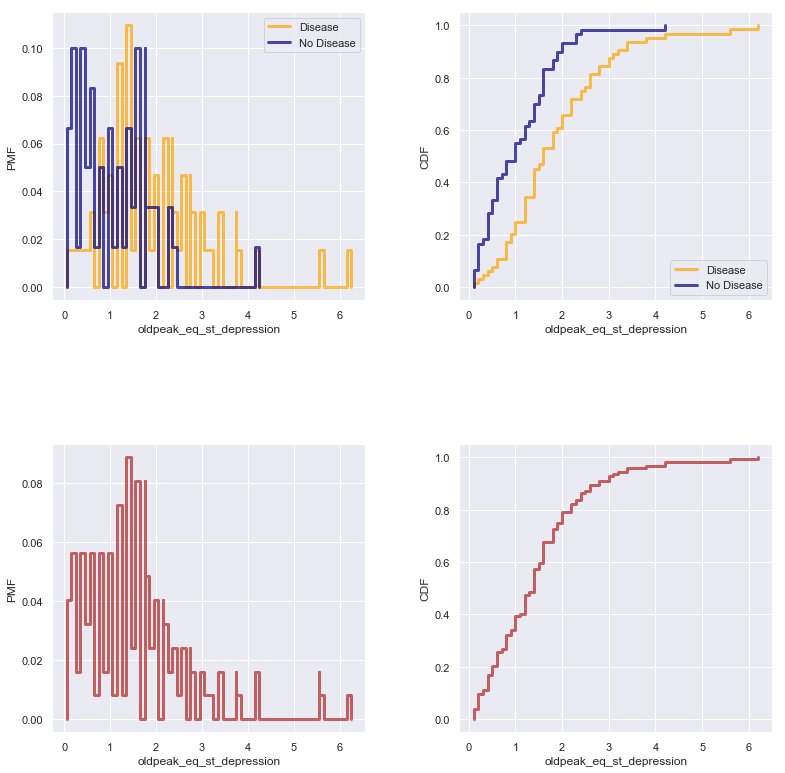

<Figure size 576x432 with 0 Axes>

In [27]:
thinkplot.Figure(figsize=(6, 7))

thinkplot.PrePlot(num=2, rows=2, cols=2)

var = 'oldpeak_eq_st_depression'

for i in range(1, 5):
    thinkplot.SubPlot(i, label=str(i))
    
    if (i-1)%2 == 0:
        if int((i-1)/2) > 0:
            pmf = thinkstats2.Pmf(train_new[var])
            thinkplot.Pmf(pmf, color='firebrick')
            thinkplot.Config(xlabel=var, ylabel='PMF')
        else:
            pmf_disease = thinkstats2.Pmf(heart_disease[var], label='Disease')
            pmf_no_disease = thinkstats2.Pmf(no_heart_disease[var], label='No Disease')
            thinkplot.Pmf(pmf_disease, color='orange')
            thinkplot.Pmf(pmf_no_disease, color='navy')
            thinkplot.Config(xlabel=var, ylabel='PMF')
    else:
        if int((i-1)/2) > 0:
            cdf = thinkstats2.Cdf(train_new[var])
            thinkplot.Cdf(cdf, color='firebrick')
            thinkplot.Config(xlabel=var, ylabel='CDF')
        else:
            cdf_disease = thinkstats2.Cdf(heart_disease[var], label='Disease')
            cdf_no_disease = thinkstats2.Cdf(no_heart_disease[var], label='No Disease')
            thinkplot.Cdf(cdf_disease, color='orange')
            thinkplot.Cdf(cdf_no_disease, color='navy')
            thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.5)
thinkplot.Show()

## Predictive Power of Each Feature

### Without `have_oldpeak`

In [19]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina']
t = []
for var in train.columns[:-1]:
    if var in categorical:
        formula = 'heart_disease_present ~ C(' + var + ')'
    else:
        formula = 'heart_disease_present ~ ' + var
    model = smf.logit(formula, data=train)
    results = model.fit()

    t.append((results.prsquared, var))

Optimization terminated successfully.
         Current function value: 0.625662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627229
  

In [20]:
t.sort(reverse=True)
for r2, name in t:
    print(name, r2)

thal 0.22211008393065912
exercise_induced_angina 0.1511475402871607
chest_pain_type 0.139629233886855
num_major_vessels 0.13770831838862385
oldpeak_eq_st_depression 0.11826930354836762
max_heart_rate_achieved 0.10797913151601879
slope_of_peak_exercise_st_segment 0.08923273120799136
sex 0.08695140221676123
resting_ekg_results 0.01557709847553046
age 0.01405026817582622
serum_cholesterol_mg_per_dl 0.004642434414665164
resting_blood_pressure 0.00448456503608341
fasting_blood_sugar_gt_120_mg_per_dl 8.306880368347258e-06


### With `have_oldpeak`

In [28]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina', 'have_oldpeak']
t = []
for var in train_new.columns[:-1]:
    if var in categorical:
        formula = 'heart_disease_present ~ C(' + var + ')'
    else:
        formula = 'heart_disease_present ~ ' + var
    model = smf.logit(formula, data=train_new)
    results = model.fit()

    t.append((results.prsquared, var))

Optimization terminated successfully.
         Current function value: 0.625662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.591042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627229
  

In [29]:
t.sort(reverse=True)
for r2, name in t:
    print(name, r2)

thal 0.22211008393065912
exercise_induced_angina 0.15114754028716104
chest_pain_type 0.13962923388685478
num_major_vessels 0.13770831838862385
oldpeak_eq_st_depression 0.12438299808017861
max_heart_rate_achieved 0.10797913151601868
slope_of_peak_exercise_st_segment 0.08923273120799147
sex 0.08695140221676123
have_oldpeak 0.03448570498068548
resting_ekg_results 0.015577098475530349
age 0.014050268175825997
serum_cholesterol_mg_per_dl 0.004642434414665164
resting_blood_pressure 0.00448456503608341
fasting_blood_sugar_gt_120_mg_per_dl 8.306880368125213e-06
